In this notebook, I am investigating the conformation of sister chromatids at CTCF sites.
I will be using cooltools and other libraries from open2c suit (https://open2c.github.io/)

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import seaborn as sns
import bioframe as bf
import cooler
import cooltools
import bbi

In [2]:
# ignore log10(0) warnings
warnings.simplefilter("ignore", RuntimeWarning)

## Set plotting parameters

In [3]:
mpl.rcParams.update({'pdf.fonttype': 42,
                     'ps.fonttype': 42,
                     'xtick.labelsize': 22,
                     'ytick.labelsize': 22,
                     'axes.labelsize':22,
                     'font.size': 22})

## Get chromosome arms

In [4]:
hg19_chromsizes = bf.fetch_chromsizes('hg19')
hg19_cens = bf.fetch_centromeres('hg19')
hg19_arms = bf.make_chromarms(hg19_chromsizes, hg19_cens)

## Upload scsHi-C cooler files

In [5]:
# Define the window of interest (one-sided)
flank = 1000000

# Define the resolution of the Hi-C data 
resolution = 20000

In [6]:
## CTCF data
perturbation = 'WT'

# Load scsHi-C data based on the variable specified above (window and binsize)
clrs = {interType:
        cooler.Cooler(
            f'./cooler/G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{resolution}')
        for interType in ["cis", "trans"]
        }

## Fix the sorting of the hg_19 arms to match coolers 

In [7]:
hg19_arms.chrom = hg19_arms.chrom.astype("category")
hg19_arms.chrom = hg19_arms.chrom.cat.set_categories(clrs["trans"].chromnames)
hg19_arms = hg19_arms.sort_values(["chrom","start"])
hg19_arms.reset_index(inplace = True, drop = True)

## Calculate expected Hi-C values

In [8]:
# Calculate expected values 
expClrs = {interType:
       cooltools.expected_cis (clrs[interType], view_df=hg19_arms, smooth = True, aggregate_smoothed=True, nproc=2, chunksize=1_000_000)
       for interType in ["cis", "trans"]
      }

## Upload CTCF peaks

In [9]:
center = 'CTCF'
path = './data/MACS2/ctcf_peaks_at_motifs.bed'

ctcf = pd.read_csv(path, sep = '\t',header = None , index_col = False)[[0,1,2,3]]
ctcf.columns = ["chrom", "start", "end", "strand"]
ctcf.loc [:, "mid"] = ((ctcf["end"] + ctcf["start"])/2).astype(int)
ctcf

,chrom,start,end,strand,mid
0,chr1,10021,10611,-,10316
1,chr1,91071,91614,+,91342
2,chr1,237590,237915,+,237752
3,chr1,521320,521733,+,521526
4,chr1,713890,714637,-,714263
...,...,...,...,...,...
53912,chrY,10021990,10024708,-,10023349
53913,chrY,13311559,13312341,-,13311950
53914,chrY,13402717,13403663,+,13403190
53915,chrY,13636603,13636905,-,13636754


In [10]:
# Some CTCF sites might be located too close in the genome and interfere with analysis.
# I will collapse the sites falling into the same size genomic bins as the resolution 
# of my Hi-C data:

ctcf = bf.cluster(ctcf, min_dist=resolution)\
    .drop_duplicates('cluster')\
    .reset_index(drop=True)
ctcf

,chrom,start,end,strand,mid,cluster,cluster_start,cluster_end
0,chr1,10021,10611,-,10316,0,10021,10611
1,chr1,91071,91614,+,91342,1,91071,91614
2,chr1,237590,237915,+,237752,2,237590,237915
3,chr1,521320,521733,+,521526,3,521320,521733
4,chr1,713890,714637,-,714263,4,713890,714637
...,...,...,...,...,...,...,...,...
31346,chrY,10005743,10006693,+,10006218,31346,10005743,10024708
31347,chrY,13311559,13312341,-,13311950,31347,13311559,13312341
31348,chrY,13402717,13403663,+,13403190,31348,13402717,13403663
31349,chrY,13636603,13636905,-,13636754,31349,13636603,13636905


## Generate and plot ICE-corrected pile-ups centered at CTCF peaks

In [11]:
# generate ICE-correted Hi-C pile-ups
matricesICCF = {}
for rType in ["cis", "trans"]:
    snippets = cooltools.pileup(clrs[rType], ctcf, view_df=hg19_arms, flank=flank)
    mask = np.array(ctcf.strand == '-', dtype=bool)
    snippets[mask] = np.flip(snippets[mask])
    matrix = np.nanmean(snippets, axis=0)
    matricesICCF [rType] = matrix

In [12]:
# set plotting parameters
# set colormap 
cmapICCF = cl.LinearSegmentedColormap.from_list("fall", colors=["white", "orange" ,"red", "black"], N=256)
# set ticks parameters
ticks_pixels = np.linspace(0, flank*2//resolution, 3)
ticks_kbp = (((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int))

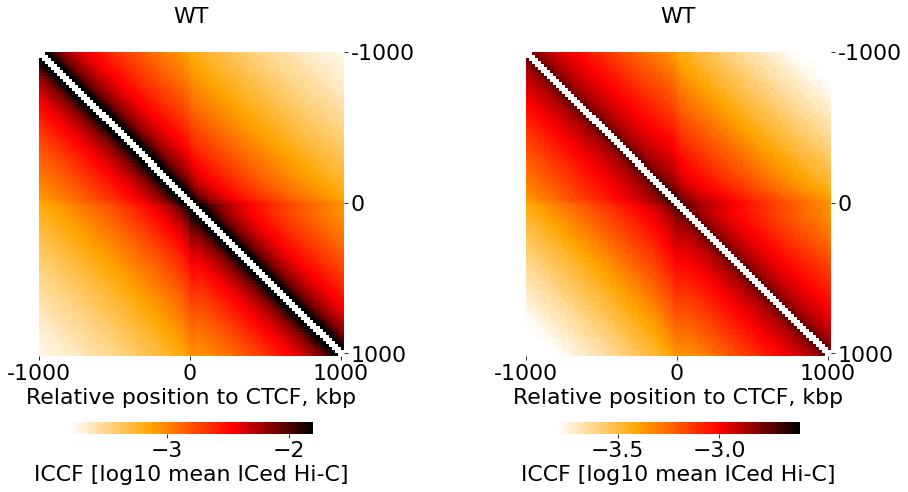

In [13]:
# plot ICE-correted Hi-C pile-ups

f,axs = plt.subplots(figsize=(16, 8), ncols=2)

ax = axs [0]
ax.set_title(f'{perturbation}\n', fontsize = 22)
cis = np.log10(matricesICCF['cis']).copy()
im = sns.heatmap(cis, ax=ax,
            cmap=cmapICCF, vmin= -3.8, vmax= -1.8,
            square=True,
            rasterized=True,
            cbar_kws={'orientation':'horizontal', 'shrink':0.6, 'label':"ICCF [log10 mean ICed Hi-C]"},
            xticklabels=False,
            yticklabels=False)
ax.set_xticks(ticks_pixels)
ax.set_xticklabels(ticks_kbp)
ax.set_yticks(ticks_pixels)
ax.yaxis.tick_right()
ax.set_yticklabels(ticks_kbp)
ax.set_xlabel(f'Relative position to {center}, kbp')

ax = axs [1]
ax.set_title(f'{perturbation}\n', fontsize = 22)
trans = np.log10(matricesICCF['trans']).copy()
im = sns.heatmap(trans, ax=ax,
            cmap=cmapICCF, vmin= -3.8, vmax= -2.6,
            square=True,
            rasterized=True,
            cbar_kws={'orientation':'horizontal', 'shrink':0.6, 'label':"ICCF [log10 mean ICed Hi-C]"},
            xticklabels=False,
            yticklabels=False)

ax.set_xticks(ticks_pixels)
ax.set_xticklabels(ticks_kbp)
ax.set_yticks(ticks_pixels)
ax.yaxis.tick_right()
ax.set_yticklabels(ticks_kbp)
ax.set_xlabel(f'Relative position to {center}, kbp')
plt.show()
plt.show()

## Generate and plot observed-over-expected pile-ups centered at peaks of ProteinX

In [14]:
# generate observed-over-expected Hi-C pile-ups
matricesObsExp = {}
for rType in ["cis", "trans"]:
    snippets = cooltools.pileup(clrs[rType], ctcf, view_df=hg19_arms, expected_df=expClrs[rType], flank=flank)
    mask = np.array(ctcf.strand == '-', dtype=bool)
    snippets[mask] = np.flip(snippets[mask])
    matrix = np.nanmean(snippets, axis=0)
    matricesObsExp [rType] = matrix

In [15]:
# set plotting parameters
# set colormap 
cmap = mpl.cm.get_cmap('RdBu_r')
# set heatmap range 
vmin = - 0.5
vmax = 0.5

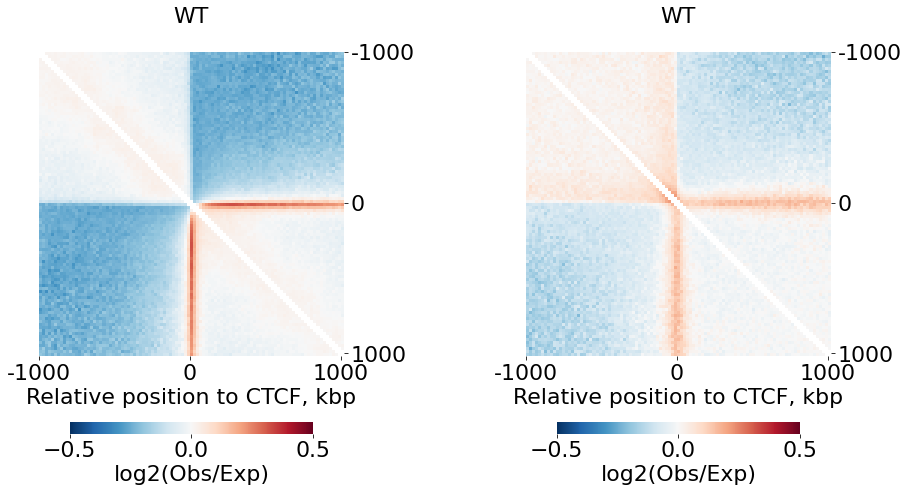

In [16]:
# plot observed-over-expected Hi-C pile-ups
f,axs = plt.subplots(figsize=(16, 8), ncols=2)

ax = axs [0]
ax.set_title(f'{perturbation}\n', fontsize = 22)
cis = np.log2(matricesObsExp['cis'])
im = sns.heatmap(cis, ax=ax,
            cmap=cmap, vmin=vmin, vmax=vmax,
            square=True,
            cbar_kws={'orientation':'horizontal', 'shrink':0.6, 'label':'log2(Obs/Exp)'},
            xticklabels=False,
            yticklabels=False)
ax.set_xticks(ticks_pixels)
ax.set_xticklabels(ticks_kbp)
ax.set_yticks(ticks_pixels)
ax.yaxis.tick_right()
ax.set_yticklabels(ticks_kbp)
ax.set_xlabel(f'Relative position to {center}, kbp')

ax = axs [1]
ax.set_title(f'{perturbation}\n', fontsize = 22)
trans = np.log2(matricesObsExp['trans'])
im = sns.heatmap(trans, ax=ax,
            cmap=cmap, vmin=vmin, vmax=vmax,
            square=True,
            cbar_kws={'orientation':'horizontal', 'shrink':0.6, 'label':'log2(Obs/Exp)'},
            xticklabels=False,
            yticklabels=False)
ax.set_xticks(ticks_pixels)
ax.set_xticklabels(ticks_kbp)
ax.set_yticks(ticks_pixels)
ax.yaxis.tick_right()
ax.set_yticklabels(ticks_kbp)
ax.set_xlabel(f'Relative position to {center}, kbp')
plt.show();